In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, Point
import json
import matplotlib.pyplot as plt
import requests
import plotly.express as px
import io
from PIL import Image
import zipfile
import rasterio
from rasterio.io import MemoryFile
import requests
from io import BytesIO
from rasterio.features import geometry_mask
import rasterio
from rasterio.plot import show
from shapely.geometry import mapping
import numpy as np
import matplotlib.cm as cm
import requests
import folium
from matplotlib.colors import LogNorm
import networkx as nx
import osmnx as ox
from rasterio.plot import show
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import ee
import geopandas as gpd
import pandas as pd
from h3 import h3
from tobler.util import h3fy
from tobler.area_weighted import area_interpolate
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib.patches as mpatches
import warnings
import geopandas
import pandas
import rioxarray
import rasterio
import xarray
import fsspec
import os
import h3
from shapely.geometry import shape, mapping
from shapely.ops import cascaded_union
warnings.filterwarnings('ignore')
%matplotlib inline

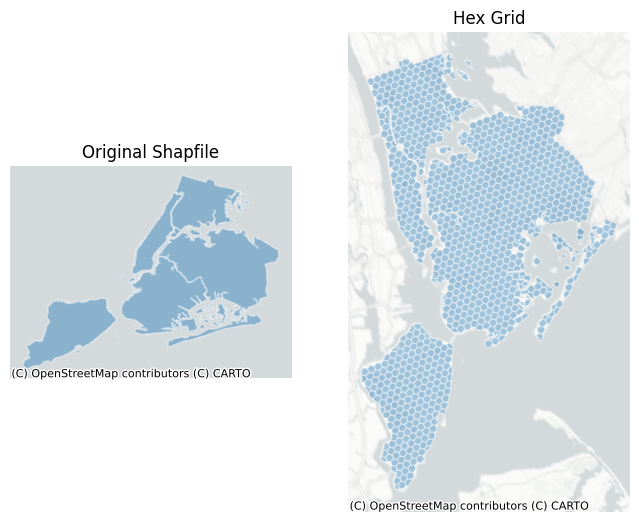

In [3]:
# New York Sate (FIFP=36) county shapfile data
url = "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile"
nyc_county_data = gpd.read_file(url)
hexes = h3fy(nyc_county_data.to_crs('epsg:4326'), resolution=8, clip=True).to_crs("epsg:26910")


fig, axs = plt.subplots(1,2, figsize=(8,8))
axs=axs.flatten()

nyc_county_data.plot(ax=axs[0], alpha=0.4, linewidth=1, edgecolor='white')
hexes.plot(ax=axs[1], alpha=0.4, linewidth=1, edgecolor='white')

axs[0].set_title('Original Shapfile')
axs[1].set_title('Hex Grid')

for i,_ in enumerate(axs):
    cx.add_basemap(
        axs[i],
        crs=hexes.crs.to_string(),
        source=cx.providers.CartoDB.PositronNoLabels)
    axs[i].axis('off')

In [4]:
hexes.head()

,geometry
hex_id,
882a106e0dfffff,"POLYGON ((4651210.325 5803800.724, 4651011.549..."
882a106e63fffff,"POLYGON ((4651011.549 5804403.291, 4651210.325..."
882a106e67fffff,"POLYGON ((4649932.570 5803993.461, 4650131.338..."
882a106e47fffff,"POLYGON ((4652331.853 5805922.146, 4652530.701..."
882a106e6bfffff,"POLYGON ((4651252.813 5805512.142, 4651451.652..."


Raster TIF file

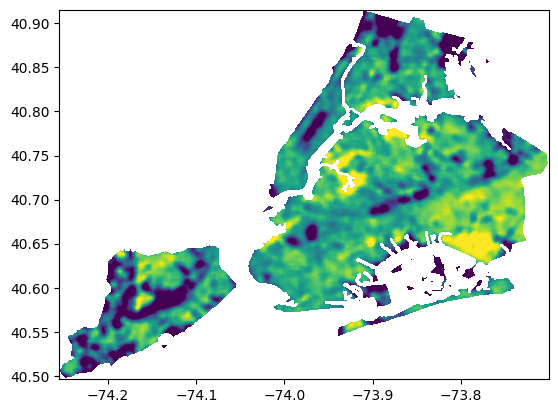

<Axes: >

In [5]:
# Load the raster data
lst_raster = rasterio.open('f_deviation_smooth.tif')

# Load the vector data (hexagons)
hexagons = hexes

# Optionally visualize the raster
show(lst_raster)

In [6]:
print("Raster CRS:", lst_raster.crs)
print("Vector CRS:", hexagons.crs)

Raster CRS: EPSG:4326
Vector CRS: epsg:26910


In [7]:
# Reproject the hexagons to match the raster CRS
hexagons = hexagons.to_crs(lst_raster.crs)
hexagons.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
def get_raster_value_at_point(raster, x, y):
    """Get raster value at a given point (x, y)."""
    for val in raster.sample([(x, y)]):
        return val[0]  # assuming single band raster

# Recalculate centroids in the new CRS
hexagons['centroid'] = hexagons.geometry.centroid

# Extract LST values again
hexagons['lst_value'] = hexagons['centroid'].apply(
    lambda point: get_raster_value_at_point(lst_raster, point.x, point.y)
)

# Replace no data values with NaN or another identifier
# hexagons['lst_value'] = hexagons['lst_value'].replace(-3.4028235e+38, np.nan)

# Check the updated unique values
hexagons['lst_value'].nunique()

938

In [9]:
# Convert centroid geometry to numeric columns
hexagons['centroid_x'] = hexagons['centroid'].x
hexagons['centroid_y'] = hexagons['centroid'].y

# Now drop the centroid geometry column
hexagons.drop(columns=['centroid'], inplace=True)

# Attempt to save the GeoDataFrame again
# hexagons.to_file('corrected_hexagons_with_lst_values.geojson', driver='GeoJSON')

hexagons.head()

,geometry,lst_value,centroid_x,centroid_y
hex_id,,,,
882a106e0dfffff,"POLYGON ((-74.24006 40.50163, -74.23813 40.506...",-5.614251,-74.234173,40.503574
882a106e63fffff,"POLYGON ((-74.23813 40.50608, -74.24006 40.501...",3.041130,-74.244470,40.505012
882a106e67fffff,"POLYGON ((-74.24888 40.50840, -74.25081 40.503...",-1.645526,-74.252502,40.506940
882a106e47fffff,"POLYGON ((-74.21910 40.50927, -74.22103 40.504...",-8.000000,-74.225444,40.508206
882a106e6bfffff,"POLYGON ((-74.22985 40.51159, -74.23179 40.507...",2.849392,-74.236196,40.510528


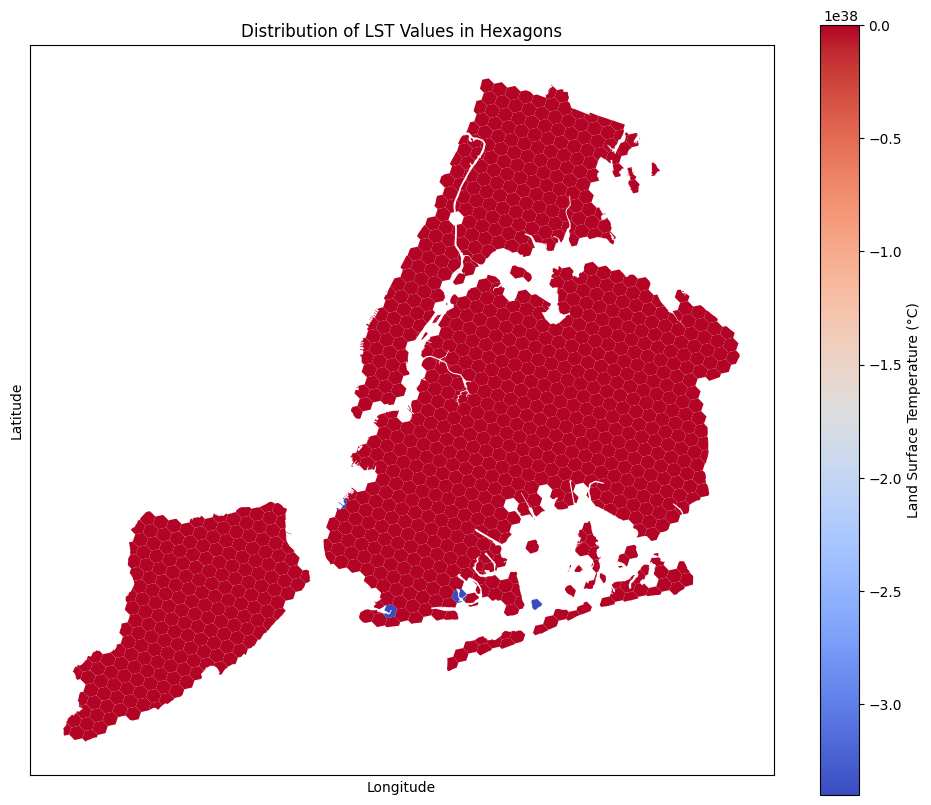

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
# Create a color map for the LST values, choose a colormap appropriate for temperature
hexagons.plot(column='lst_value', ax=ax, legend=True, cmap='coolwarm', legend_kwds={'label': "Land Surface Temperature (°C)"})

# Optional: Set the title and other plot settings
ax.set_title('Distribution of LST Values in Hexagons')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Remove the axes for a cleaner look
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Google Earth Engine

In [11]:
ee.Authenticate()
ee.Initialize(project='ee-zeyuwu2001')

In [12]:
# Define the MODIS dataset and filter by date
dataset = ee.ImageCollection('MODIS/061/MOD11A1') \
    .filter(ee.Filter.date('2023-03-01', '2023-05-31'))

# Select the land surface temperature band
landSurfaceTemperature = dataset.select('LST_Day_1km')

# Define the visualization parameters
landSurfaceTemperatureVis = {
    'min': 14000.0,
    'max': 16000.0,
    'palette': [
        '040274', '040281', '0502a3', '0502b8', '0502ce', '0502e6',
        '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
        '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
        'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
        'ff0000', 'de0101', 'c21301', 'a71001', '911003'
    ]
}

# Set the center of the map
center_coords = [46.529, 6.746]
zoom_level = 2

# Create a folium map centered on the specified coordinates and zoom level
map_center = folium.Map(location=center_coords[::-1], zoom_start=zoom_level)

# Add the land surface temperature layer to the map
map_id_dict = ee.Image(landSurfaceTemperature.first()).getMapId(landSurfaceTemperatureVis)
folium.TileLayer(
    tiles=map_id_dict['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name='Land Surface Temperature',
    overlay=True,
    control=True
).add_to(map_center)

# Display the map
display(map_center)

In [13]:
# Import the LST image collection
lstCollection = ee.ImageCollection('MODIS/061/MOD11A1') \
    .filter(ee.Filter.date('2023-03-01', '2023-05-31')) \
    .select('LST_Day_1km')

# Calculate the mean LST for the spring season
meanLST = lstCollection.mean().multiply(0.02).subtract(273.15)

# Define the region of interest (NYC)
roi = ee.Geometry.Rectangle([-74.2591, 40.4774, -73.7003, 40.9176])

# Generate a random point within the ROI
randomPoint = ee.FeatureCollection.randomPoints(roi, 1)

# Create a 1km buffer around the random point
buffer = randomPoint.geometry().buffer(500)

# Generate random points within the buffered region
randomPoints = ee.FeatureCollection.randomPoints(buffer, 100)

# Create circular polygons around the random points
def create_hex(point):
    return point.buffer(500, 100).set('hex_id', point.id())

hexGrid = randomPoints.map(create_hex)

# Calculate the mean LST value for each hex grid cell
hexLST = meanLST.reduceRegions(collection=hexGrid, reducer=ee.Reducer.mean(), scale=1000)

# Get the mean LST value for a random hex grid cell
randomHex = hexLST.randomColumn()
meanLSTValue = randomHex.first().get('mean').getInfo()

# Print the mean LST value
print('Mean LST value for a random hex grid cell:', meanLSTValue)

# Create a folium map centered on the buffered region
map_center = buffer.centroid().coordinates().getInfo()[::-1]
m = folium.Map(location=map_center, zoom_start=10)

# Add the hex grid to the map
hexGrid_geojson = ee.FeatureCollection(hexGrid).getInfo()
folium.GeoJson(hexGrid_geojson, style_function=lambda feature: {
    'fillColor': 'white',
    'color': 'black',
    'weight': 1,
    'fillOpacity': 0.7
}).add_to(m)

# Define the selected hex cell
selectedHex = ee.Feature(randomHex.first())

# Highlight the randomly selected hex cell
selectedHex_geojson = ee.FeatureCollection(selectedHex).getInfo()
folium.GeoJson(selectedHex_geojson, style_function=lambda feature: {
    'fillColor': 'red',
    'color': 'red',
    'weight': 2,
    'fillOpacity': 0.7
}).add_to(m)

# Display the map
display(m)

Mean LST value for a random hex grid cell: 21.013888888888914


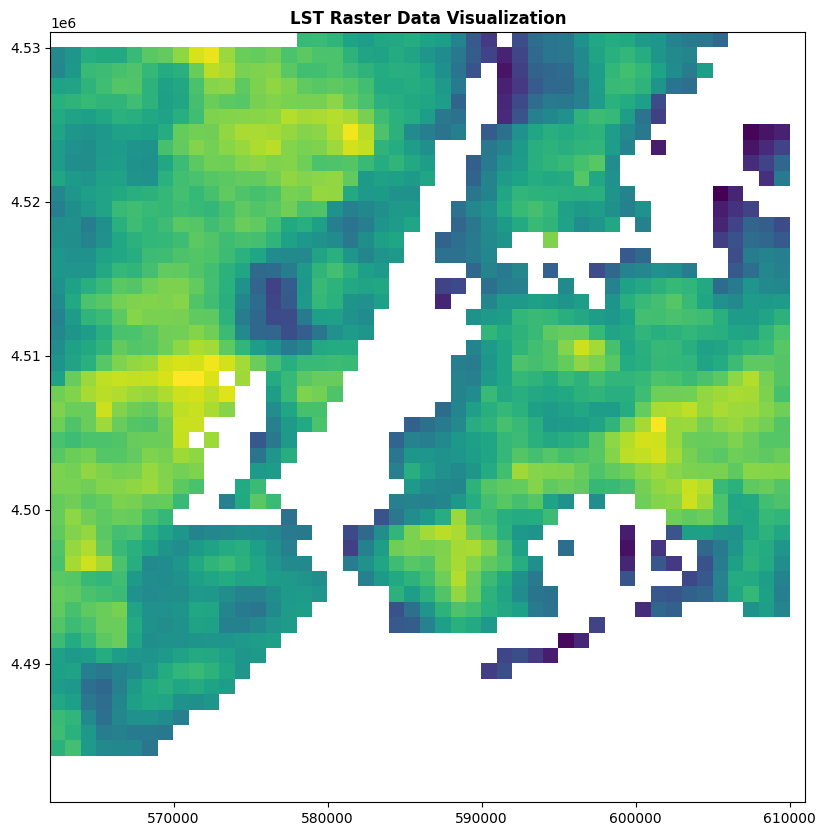

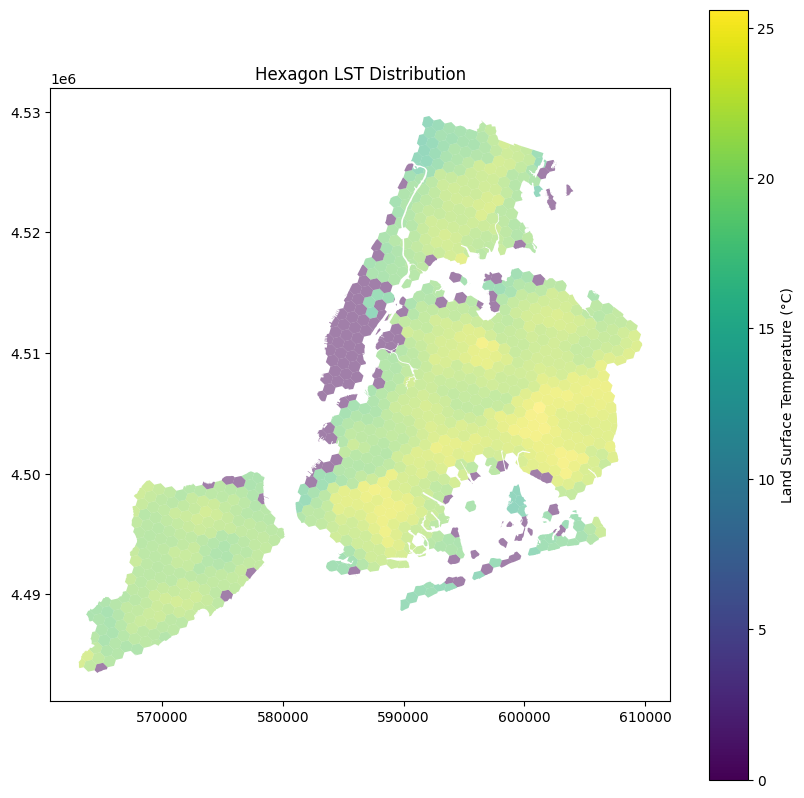

'\n# Define the area of interest\nnyc_bounds = ee.Geometry.Rectangle([-74.2591, 40.4774, -73.7004, 40.9176])\n\n# Access MODIS LST data for daytime temperatures during Spring 2023\nlst_data = ee.ImageCollection(\'MODIS/061/MOD11A1\')     .filterDate(\'2023-01-01\', \'2023-12-31\')     .filterBounds(nyc_bounds)     .select(\'LST_Day_1km\')     .mean()     .multiply(0.02)     .subtract(273.15)  # Convert to Celsius\n\n# Clip the data to the bounds of NYC and adjust the scale\nscale = 2000  # Increased scale to reduce image resolution and size\nlst_clipped = lst_data.clip(nyc_bounds)\n\n# Generate a download URL for the clipped image at a reduced scale\nurl = lst_clipped.getDownloadURL({\n    \'scale\': scale,\n    \'crs\': \'EPSG:32618\',\n    \'format\': \'GeoTIFF\'\n})\n\n# Download the image using requests\nresponse = requests.get(url)\nif response.status_code == 200:\n    with MemoryFile(response.content) as memfile:\n        with memfile.open() as dataset:\n            # Load and al

In [14]:
ee.Authenticate()
ee.Initialize(project='ee-zeyuwu2001')

# Define the area of interest
nyc_bounds = ee.Geometry.Rectangle([-74.2591, 40.4774, -73.7004, 40.9176])

# Access MODIS LST data for daytime temperatures during Spring 2023
lst_data = ee.ImageCollection('MODIS/061/MOD11A1') \
    .filterDate('2023-01-01', '2023-12-31') \
    .filterBounds(nyc_bounds) \
    .select('LST_Day_1km') \
    .mean() \
    .multiply(0.02) \
    .subtract(273.15)  # Convert to Celsius

# Clip the data to the bounds of NYC and adjust the scale
scale = 1000  # Increased scale to reduce image resolution and size
lst_clipped = lst_data.clip(nyc_bounds)

# Generate a download URL for the clipped image at a reduced scale
url = lst_clipped.getDownloadURL({
    'scale': scale,
    'crs': 'EPSG:32618',
    'format': 'GeoTIFF'
})

# Download the image using requests
response = requests.get(url)
if response.status_code == 200:
    with MemoryFile(response.content) as memfile:
        with memfile.open() as dataset:
            # Load and align CRS for hexagon vector data
            hexagons = hexes
            hexagons = hexagons.to_crs(dataset.crs)

            # Sample LST values at hexagon centroids using the corrected method
            hexagons['centroid'] = hexagons.geometry.centroid
            hexagons['lst_value'] = hexagons['centroid'].apply(
                lambda point: next(dataset.sample([(point.x, point.y)]))[0]
            )

            # Plotting the raster data
            plt.figure(figsize=(10, 10))
            show(dataset, cmap='viridis', title='LST Raster Data Visualization')
            plt.show()

            # Plotting the hexagons with LST values
            fig, ax = plt.subplots(figsize=(10, 10))
            hexagons.plot(ax=ax, column='lst_value', alpha=0.5, legend=True,
                          legend_kwds={'label': "Land Surface Temperature (°C)"})
            plt.title('Hexagon LST Distribution')
            plt.show()

else:
    print("Failed to download data:", response.status_code)

'''
# Define the area of interest
nyc_bounds = ee.Geometry.Rectangle([-74.2591, 40.4774, -73.7004, 40.9176])

# Access MODIS LST data for daytime temperatures during Spring 2023
lst_data = ee.ImageCollection('MODIS/061/MOD11A1') \
    .filterDate('2023-01-01', '2023-12-31') \
    .filterBounds(nyc_bounds) \
    .select('LST_Day_1km') \
    .mean() \
    .multiply(0.02) \
    .subtract(273.15)  # Convert to Celsius

# Clip the data to the bounds of NYC and adjust the scale
scale = 2000  # Increased scale to reduce image resolution and size
lst_clipped = lst_data.clip(nyc_bounds)

# Generate a download URL for the clipped image at a reduced scale
url = lst_clipped.getDownloadURL({
    'scale': scale,
    'crs': 'EPSG:32618',
    'format': 'GeoTIFF'
})

# Download the image using requests
response = requests.get(url)
if response.status_code == 200:
    with MemoryFile(response.content) as memfile:
        with memfile.open() as dataset:
            # Load and align CRS for hexagon vector data
            hexagons = hexes
            hexagons = hexagons.to_crs(dataset.crs)

            # Sample LST values at hexagon centroids using the corrected method
            hexagons['centroid'] = hexagons.geometry.centroid
            hexagons['lst_value'] = hexagons['centroid'].apply(
                lambda point: next(dataset.sample([(point.x, point.y)]))[0]
            )

            # Plotting the raster data
            fig, ax = plt.subplots(figsize=(10, 10))
            show(dataset, ax=ax, cmap='viridis', title='LST Raster Data Visualization')

            # Overlay the hexagons with LST values
            hexagons.plot(ax=ax, column='lst_value', alpha=0.5, legend=True,
                          legend_kwds={'label': "Land Surface Temperature (°C)"})
            plt.show()

else:
    print("Failed to download data:", response.status_code)
'''

In [15]:
hexagons.head()

,geometry,centroid,lst_value
hex_id,,,
882a106e0dfffff,"POLYGON ((564391.406 4483712.571, 564550.811 4...",POINT (564888.326 4483933.131),0.000000
882a106e63fffff,"POLYGON ((564550.811 4484208.004, 564391.406 4...",POINT (564014.500 4484085.159),20.925329
882a106e67fffff,"POLYGON ((563637.579 4484457.739, 563478.197 4...",POINT (563332.176 4484293.380),22.617778
882a106e47fffff,"POLYGON ((566159.771 4484576.585, 566000.320 4...",POINT (565623.445 4484453.736),20.245281
882a106e6bfffff,"POLYGON ((565246.554 4484826.329, 565087.125 4...",POINT (564710.223 4484703.477),20.925329


In [16]:
hexagons.shape

(1055, 3)

In [17]:
hexagons.lst_value.nunique()

701

In [18]:
hexagons.to_csv('NYC_LST_HEX.csv')

Code to download Google Earth Engine .tif raster data

In [19]:
ee.Authenticate()
ee.Initialize(project='ee-zeyuwu2001')

# Define the area of interest (AOI) with coordinates.
aoi = ee.Geometry.Polygon([
    [[-122.4481, 37.7663], [-122.5012, 37.7335], [-122.4385, 37.7081],
     [-122.3832, 37.7277], [-122.4269, 37.7521], [-122.4481, 37.7663]]
])

# Create an image collection of MODIS LST data, selecting the daytime LST band
lstCollection = ee.ImageCollection('MODIS/061/MOD11A1') \
    .filterDate('2023-03-01', '2023-05-31') \
    .select('LST_Day_1km') \
    .mean() \
    .clip(aoi)

# Specify the parameters for exporting the image as a GeoTIFF
task = ee.batch.Export.image.toDrive(
    image=lstCollection,
    description='LST_Day_1km_export',
    folder='GEE_Exports',
    fileNamePrefix='LST_Day_1km',
    scale=1000,
    region=aoi.bounds().getInfo()['coordinates'],
    fileFormat='GeoTIFF'
)

# Start the export task
task.start()

print("Export task has been started! Check the 'Tasks' tab in GEE Code Editor or your Google Drive 'GEE_Exports' folder once the task completes.")

Export task has been started! Check the 'Tasks' tab in GEE Code Editor or your Google Drive 'GEE_Exports' folder once the task completes.
